<a href="https://colab.research.google.com/github/lkamat/classification/blob/master/FakevsRealNews_ULMFIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd /content/drive/My Drive/apps/Colab Notebooks

/content/drive/My Drive/apps/Colab Notebooks


## Classify Fake vs real News dataset using Transfer Learning. (ULMFit Language model trained by Fast.ai)


In [5]:
#install Pytorch
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
    100% |████████████████████████████████| 576.2MB 25kB/s 


In [6]:
# Install Fast.ai
!pip install fastai

    100% |████████████████████████████████| 17.3MB 2.2MB/s 
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


In [0]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [0]:
# Import `fake_or_real_news.csv` 
df = pd.read_csv("https://s3.amazonaws.com/assets.datacamp.com/blog_assets/fake_or_real_news.csv")

In [75]:
df.shape


(6335, 4)

In [81]:
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


### Lets use only Label to classify and text

In [0]:
df = df[['label', 'text']]
df = df.reset_index(drop = True)

In [87]:
df.head()

,label,text
0,FAKE,"Daniel Greenfield, a Shillman Journalism Fello..."
1,FAKE,Google Pinterest Digg Linkedin Reddit Stumbleu...
2,REAL,U.S. Secretary of State John F. Kerry said Mon...
3,FAKE,"— Kaydee King (@KaydeeKing) November 9, 2016 T..."
4,REAL,It's primary day in New York and front-runners...


In [88]:
df.sample(5)

,label,text
3671,REAL,"Whoever dubbed Tuesday, April 26 the “Acela Pr..."
4434,REAL,Washington (CNN) Donald Trump is attempting to...
6224,REAL,Faced with an unending scandal about her use o...
4638,REAL,Political columnists Michael Gerson and EJ Dio...
3942,FAKE,Email \nThe Pew Research Center released a rep...


### Check for balanced dataset


In [89]:
df['label'].value_counts()

REAL    3171
FAKE    3164
Name: label, dtype: int64

#Data Preprocessing
### Clean our text by retaining only alphabets and removing everything else

In [0]:
df['text'] = df['text'].str.replace("[^a-zA-Z]", " ")

In [0]:
#Now let’s split our cleaned dataset into training and validation sets in a 60:40 ratio.

from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df, stratify = df['label'], test_size = 0.4, random_state = 12)

In [92]:
df_trn.shape, df_val.shape

((3801, 2), (2534, 2))

#Data Preparation
### prepare our data for the language model and for the classification model separately. 



In [0]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

##Fine-Tuning the Pre-Trained Model and Making Predictions
##We can use the data_lm object we created earlier to fine-tune a pre-trained language model. We can create a learner object, ‘learn’, that will directly create a model, download the pre-trained weights, and be ready for fine-tuning:

In [0]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.7)

In [95]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


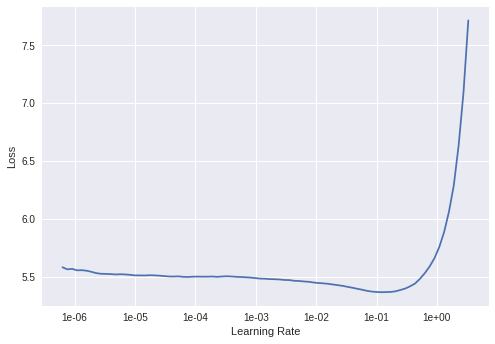

In [96]:
learn.recorder.plot()

In [97]:
# Run one epoch with lower layers 
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))


epoch,train_loss,valid_loss,accuracy,time
0,4.914933,4.515143,0.256356,08:47


In [98]:
# Run for many epochs with all layers unfrozen
learn.unfreeze()
learn.fit_one_cycle(cyc_len=10, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.689369,4.357029,0.277343,09:59
1,4.467308,4.219299,0.288084,09:59
2,4.278418,4.117074,0.296171,10:00
3,4.137014,4.044222,0.302475,10:00
4,4.052101,3.997787,0.307186,10:00
5,3.942822,3.964703,0.310845,10:00
6,3.866849,3.942923,0.313064,10:00
7,3.766207,3.930918,0.314563,10:00
8,3.696566,3.925698,0.315072,10:01
9,3.696716,3.924939,0.315173,10:00


## Fine-tuned encoder layer’s weights are then saved for use during the classification stage.

In [0]:
# Save the fine-tuned encoder
learn.save_encoder('/content/drive/My Drive/apps/Colab Notebooks/fakerealnewsft_enc')

##Fine-tuning the classifier
##This step involves creating a classifier object [source] that can predict a class label once we re-train the model as a classifier. 
##The same network structure is still used for this task — the output layer is defined in a way that takes into account the number of classes we want to predict in our data.

In [100]:
# Classifier learner 
learn = text_classifier_learner(data_clas,arch=AWD_LSTM, drop_mult=0.5)
learn.load_encoder('/content/drive/My Drive/apps/Colab Notebooks/fakerealnewsft_enc')
learn.freeze()
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.357482,0.281709,0.881215,07:22


In [101]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.300481,0.169693,0.943173,07:24


In [102]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-5,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.235055,0.147674,0.950276,11:50
1,0.226026,0.136003,0.948303,11:44
2,0.175087,0.119824,0.954617,11:29
3,0.157933,0.113653,0.958564,12:06


In [103]:
learn.predict("The concept of God as a teacher is indeed interesting")

(Category FAKE, tensor(0), tensor([0.9625, 0.0375]))

In [105]:
learn.predict("Obama signs executive order banning National Anthem in sports arena.")

(Category FAKE, tensor(0), tensor([0.8997, 0.1003]))

In [106]:
learn.predict("Dreamer detained after speaking out may be deported")

(Category FAKE, tensor(0), tensor([0.9741, 0.0259]))

In [117]:
learn.predict("U S  Secretary of State John F  Kerry said Monday that he will stop in Paris later this week ")

(Category REAL, tensor(1), tensor([0.0189, 0.9811]))

In [121]:
learn.predict(" Climate change is real")

(Category FAKE, tensor(0), tensor([0.9308, 0.0692]))

In [0]:
learn.save("/content/drive/My Drive/apps/Colab Notebooks/fakereallast")

In [123]:
df['text'][4434]

'Washington  CNN  Donald Trump is attempting to crack Hillary Clinton s blue wall  And Clinton is hoping for a surge in Latino turnout fueled by opposition to Trump   The two candidates are making a last minute dash across swing states like Florida  Pennsylvania and North Carolina as the      presidential race enters its final hours  They ve also gone north to Michigan and New Hampshire to states Democrats have won in recent cycles but could flip this year   Here are the key states and signs to study as the night unfolds   Most plausible paths to victory for Trump start with holding onto two battlegrounds that Mitt Romney won four years ago    North Carolina and Arizona    and flipping three states President Barack Obama carried  Florida  Ohio and Iowa   A loss in any of the states would severely complicate Trump s already precarious path to     electoral votes  Though if Trump clawed back Pennsylvania or Michigan from the Democrats  who have won both electoral rich states six times in

In [125]:
df['text'][3671]

'Whoever dubbed Tuesday  April    the  Acela Primary   because the five states that held primaries on that day coincide with the route of Amtrak s fastest carrier  needs a refresher in how trains and Republican presidential hopefuls run   The Washington to Boston Acela service is known for the three things  speed   quiet cars  and higher fares   You won t find those first two traits   swiftness and silence   in this boisterous  time consuming GOP affair  Expensive  yes  but not a joy ride   Here are four takeaways  now that the Republican local has completed its northeastern course   Trump Towered  I ve kept struggling with a way to best characterize Donald Trump s roll   New York last week  Connecticut  Delaware  Maryland  Pennsylvania and Rhode Island all this week   One thought  Trump      looks a lot like the American map circa the mid      s  He s conquered    of the    original colonies  New Jersey votes on June     plus most of the southeast  Except for a few states here and the

In [129]:
learn.predict("the  Acela Primary   because the five states that held primaries on that day coincide with the route of Amtrak s fastest carrier  needs a refresher in how trains and Republican presidential hopefuls run y")

(Category REAL, tensor(1), tensor([0.3685, 0.6315]))

In [124]:
learn.predict("Washington  CNN  Donald Trump is attempting to crack Hillary Clinton s blue wall") 

(Category FAKE, tensor(0), tensor([0.8238, 0.1762]))